## Model Training: Convolutional Neural Network (CNN)

The purpose of this notebook is to train several Convolutional Neural Network (CNN) models for earthquake detection and property prediction. Rather than using the raw seismic signals as training data, we use images of the earthquake waveforms and spectrograms (visual representations of the spectrum of frequencies in the signal) that were created using the `Data_Preprocessing` module and the `data_preprocessing.ipynb` notebook in this repository. Using these images, we train and evaluate the following models:

1. Classification CNN model to predict whether a signal is 'earthquake' or 'noise'
2. Regression CNN model to predict earthquake magnitude
3. Regression CNN model to predict earthquake p-wave arrival time
4. Regression CNN model to predict earthquake s-wave arrival time
5. Regression CNN model to predict earthquake source-reciever distance (km)
6. Regression CNN model to predict earthquake depth (km)

Model architectures used in this notebook are located in the `architectures` module of this repo. Training utilities including train/val/test split data preparation, evaluation functions, and plotting functions are located in the `training_utils` module of this repo.

### Environment setup

In [21]:
import gc
import sys
import time

sys.path.append('../')
sys.path.append('../../../')

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import earthquake_detection.architectures as architectures
import earthquake_detection.training_utils as training_utils

plt.ioff() # Turn off matplotlib interactive mode. Prevents  memory leakage.

### Load datasets

These datasets were pre-processed from their raw STEAD format using the `DataPreprocessing` module and `data_preprocessing` notebook contained within this repo.

In [22]:
# Load extracted raw signals
raw_signals = np.load('../../../data/STEAD/extracted_raw_signals_subsample_1000.npy')

# Load created waveform images
waveform_imgs = np.load('../../../data/STEAD/created_waveform_images_subsample_1000.npy')

# Load created spectrogram images
spectrogram_imgs = np.load('../../../data/STEAD/created_spectrogram_images_subsample_1000.npy')

# Load metadata
metadata = pd.read_feather('../../../data/STEAD/extracted_metadata_subsample_1000.feather')
metadata = metadata.reset_index()

#### Inspect image datasets and metadata to confirm they look as expected

In [23]:
spectrogram_imgs.shape

(1000, 200, 300, 3)

In [24]:
waveform_imgs.shape

(1000, 200, 400, 3)

In [25]:
metadata

,trace_name,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,...,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,chunk,weight_for_subsample
0,B084.PB_20111212104350_EV,PB,B084,EH,33.611570,-116.456370,1271.0,800.0,manual,0.55,...,None,0.5746,63.90,178.5,[15.39999962 15.5 17.10000038],[[3199.]],43:51.3,earthquake_local,1,9.706561e-07
1,B086.PB_20080618145426_EV,PB,B086,EH,33.557500,-116.531000,1392.0,800.0,manual,0.59,...,None,0.5071,56.40,330.6,[45. 46.20000076 46.29999924],[[2230.]],54:27.0,earthquake_local,1,9.706561e-07
2,B023.PB_20130513182210_EV,PB,B023,EH,46.111200,-123.078700,177.4,500.0,manual,0.63,...,None,0.9683,107.61,163.1,[12.60000038 12.10000038 11.19999981],[[3199.]],22:11.5,earthquake_local,1,9.706561e-07
3,B011.PB_20120724202107_EV,PB,B011,EH,48.649543,-123.448192,22.0,800.0,manual,0.76,...,None,0.8950,99.44,82.7,[20.39999962 26.39999962 25. ],[[3199.]],21:08.5,earthquake_local,1,9.706561e-07
4,B082.PB_20150914105733_EV,PB,B082,HH,33.598182,-116.596005,1374.8,799.0,autopicker,0.92,...,None,0.1618,17.99,123.9,[28.79999924 30.29999924 28.70000076],[[1516.]],57:35.0,earthquake_local,1,9.706561e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,AA12.GM_201802152229_NO,GM,AA12,HH,39.535230,-121.466900,385.0,NaN,None,NaN,...,None,NaN,NaN,NaN,None,None,2018-02-15 22:29:00,noise,6,4.247619e-06
996,AGG.HT_20180115030036_NO,HT,AGG,HH,39.021099,22.336000,622.0,NaN,None,NaN,...,None,NaN,NaN,NaN,None,None,2018-01-15 03:00:36,noise,6,4.247619e-06
997,PB11.TX_20200317212924_NO,TX,PB11,HH,31.935530,-104.034119,915.0,NaN,None,NaN,...,None,NaN,NaN,NaN,None,None,2020-03-17 21:29:24,noise,6,4.247619e-06
998,SCI2.AZ_20180116135506_NO,AZ,SCI2,EH,32.915000,-118.487900,486.0,NaN,None,NaN,...,None,NaN,NaN,NaN,None,None,2018-01-16 13:55:06,noise,6,4.247619e-06


In [26]:
metadata.columns

Index(['trace_name', 'network_code', 'receiver_code', 'receiver_type',
       'receiver_latitude', 'receiver_longitude', 'receiver_elevation_m',
       'p_arrival_sample', 'p_status', 'p_weight', 'p_travel_sec',
       's_arrival_sample', 's_status', 's_weight', 'source_id',
       'source_origin_time', 'source_origin_uncertainty_sec',
       'source_latitude', 'source_longitude', 'source_error_sec',
       'source_gap_deg', 'source_horizontal_uncertainty_km', 'source_depth_km',
       'source_depth_uncertainty_km', 'source_magnitude',
       'source_magnitude_type', 'source_magnitude_author',
       'source_mechanism_strike_dip_rake', 'source_distance_deg',
       'source_distance_km', 'back_azimuth_deg', 'snr_db', 'coda_end_sample',
       'trace_start_time', 'trace_category', 'chunk', 'weight_for_subsample'],
      dtype='object')

### Create subsets of earthquake-only data (no noise samples)
This is done in preparation for later training of regression models to predict earthquake parameters.

In [27]:
earthquakes_indices = np.array(list(metadata[metadata['trace_category']=='earthquake_local'].index))
raw_signals_earthquakes_only = raw_signals[earthquakes_indices]
waveform_imgs_earthquakes_only = waveform_imgs[earthquakes_indices]
spectrogram_imgs_earthquakes_only = spectrogram_imgs[earthquakes_indices]
metadata_earthquakes_only = metadata[metadata['trace_category']=='earthquake_local']

### Create labels for the classification model

In [28]:
metadata['label'] = [1 if label=='earthquake_local' else 0 for label in metadata['trace_category']]
classifier_labels = metadata['label'].values

In [29]:
classifier_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Parameter setup

In [30]:
spectrogram_kwargs = {'image_size' : (300,200)}
waveform_kwargs = {'image_size' : (400,200)}

## Model training & evaluation

### 1. Classification CNN model training & evaluation to predict whether signals are 'earthquake' or 'noise'

Epoch 1/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5668 - loss: 9.4692 - val_accuracy: 0.6562 - val_loss: 1.9571 - learning_rate: 1.0000e-06
Epoch 2/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5730 - loss: 5.8404 - val_accuracy: 0.6375 - val_loss: 1.7484 - learning_rate: 1.0000e-06
Restoring model weights from the end of the best epoch: 2.
Model baseline accuracy: 0.5
 Model baseline precision: 0.5
 Model baseline recall: 1.0
 Model baseline F1 score: 0.6666666666666666


2025-01-27 14:28:26.506890: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-27 14:28:26.535266: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step
Model accuracy: 0.675
 Model precision: 0.7397260273972602
 Model recall: 0.54
 Model F1 score: 0.6242774566473989


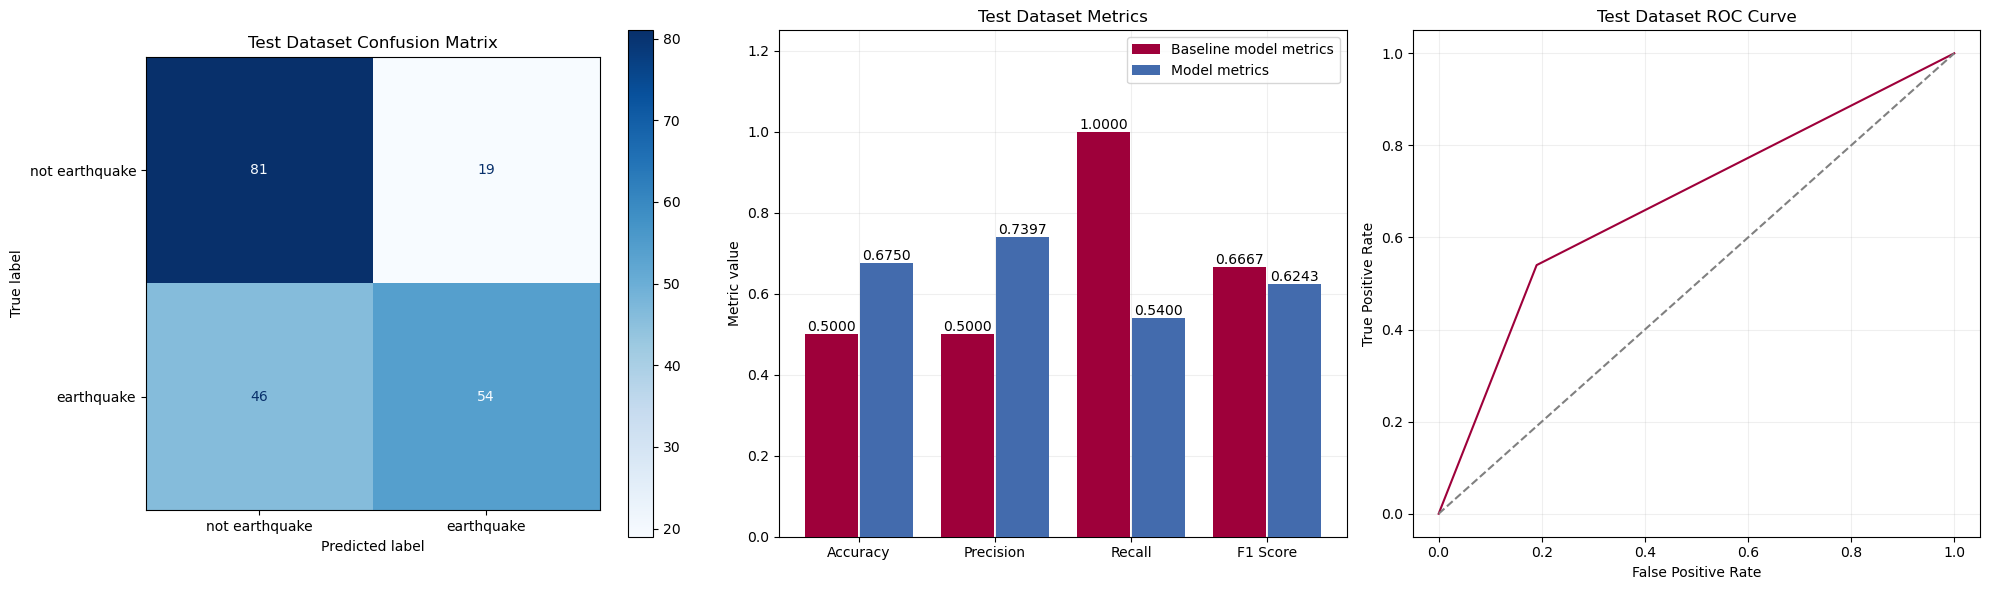

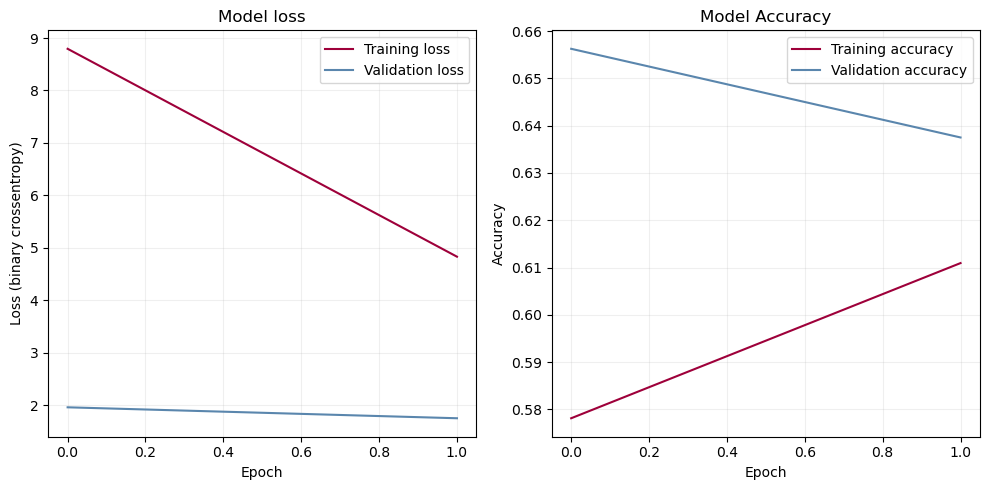

In [40]:
# Set up model callbacks
epochs = 2
callbacks_c = architectures.callbacks_setup(model_tag='cnn_classification', epochs=epochs)

# Fit model
train_dataset_c, val_dataset_c, test_dataset_c = training_utils.prepare_datasets(imgs=spectrogram_imgs, labels=classifier_labels, preproc_func=image_preprocessing, preproc_func_kwargs=spectrogram_kwargs, batch_size=32)
classifier_model = architectures.build_compile_classification_cnn(learning_rate=1e-6, loss='binary_crossentropy', metrics=['accuracy'])
classifier_history = classifier_model.fit(train_dataset_c, epochs=epochs, callbacks=callbacks_c, validation_data=val_dataset_c)

# Evaluate model and plot results
training_utils.evaluate_classification_model(classifier_model, train_dataset_c, test_dataset_c)
training_utils.plot_training_history(classifier_history)

### 2. Regression CNN model training & evaluation to predict earthquake magnitude

Epoch 1/2
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 2.2719 - mae: 1.1662 - val_loss: 1.4205 - val_mae: 0.9046 - learning_rate: 1.0000e-05
Epoch 2/2
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 1.0939 - mae: 0.7889 - val_loss: 0.6908 - val_mae: 0.5978 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 2.
Evaluating model on test dataset


2025-01-27 14:29:06.719598: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - loss: 0.5226 - mae: 0.5327
Test data MSE: 0.5226815938949585
Test data MAE: 0.5375269651412964
Getting predictions
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


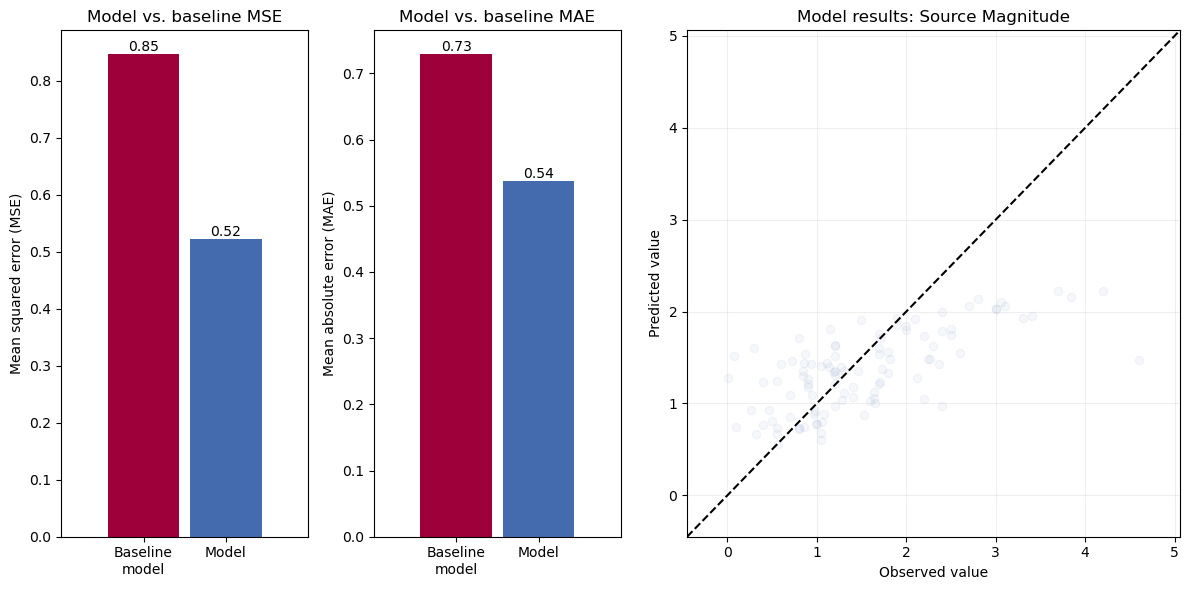

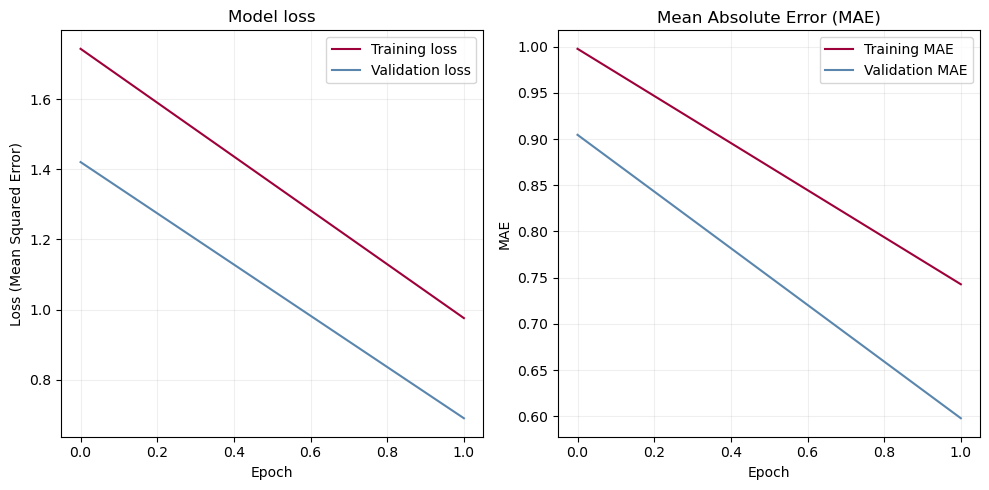

In [41]:
epochs = 2
callbacks_mag = architectures.callbacks_setup(model_tag='cnn_regression_magnitude', epochs=epochs)

labels = np.array(metadata_earthquakes_only['source_magnitude'])
train_dataset_mag, val_dataset_mag, test_dataset_mag = training_utils.prepare_datasets(imgs=spectrogram_imgs_earthquakes_only, labels=labels, preproc_func=architectures.image_preprocessing, preproc_func_kwargs=spectrogram_kwargs, use_scaler=False, batch_size=64)
model_magnitude = architectures.build_compile_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_magnitude_history = model_magnitude.fit(train_dataset_mag, epochs=epochs, callbacks=callbacks_mag, validation_data=val_dataset_mag)

training_utils.evaluate_regression_model(model_magnitude, train_dataset_mag, test_dataset_mag, 'Source Magnitude', scaler=None)
training_utils.plot_training_history(model_magnitude_history)

### 3. Regression CNN model training & evaluation to predict earthquake P-wave arrival time

Epoch 1/2
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 464539.3750 - mae: 658.2844 - val_loss: 416007.5312 - val_mae: 627.4320 - learning_rate: 1.0000e-05
Epoch 2/2
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 426630.5312 - mae: 629.3654 - val_loss: 371952.7188 - val_mae: 591.2585 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 2.
Evaluating model on test dataset
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 347016.5625 - mae: 561.7847
Test data MSE: 343802.6875
Test data MAE: 558.5864868164062
Getting predictions
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/stepWARNING:tensorflow:6 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x172b84360> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For

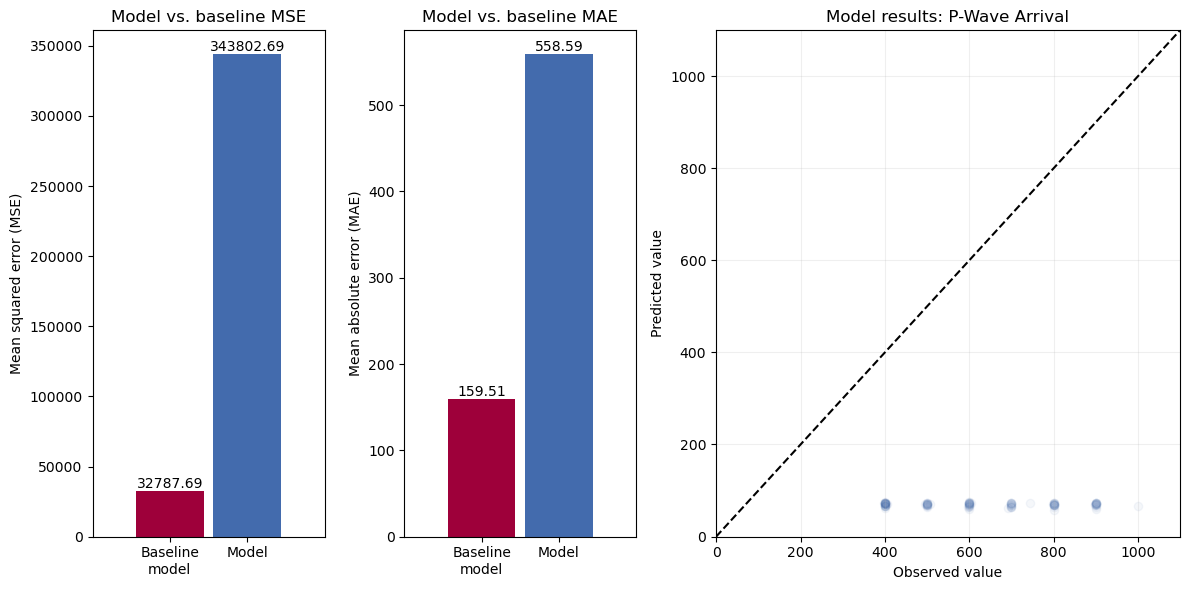

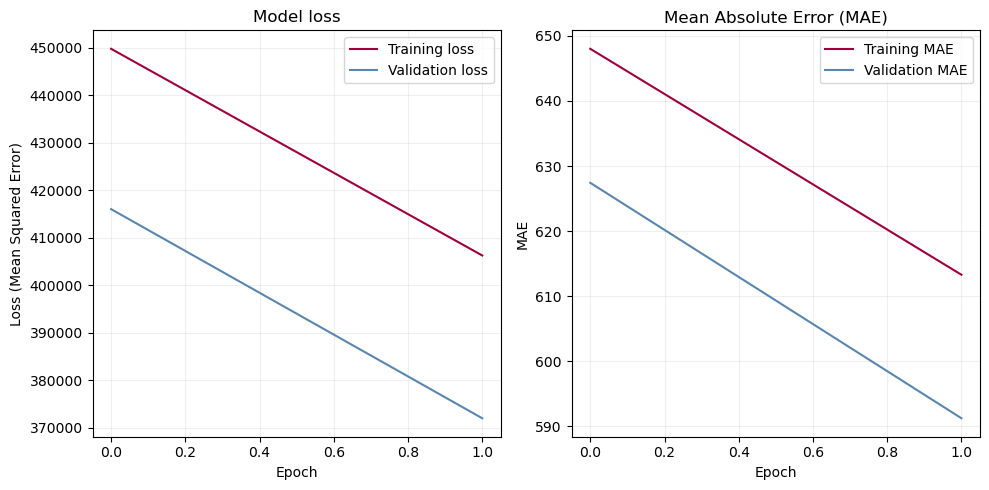

In [42]:
# Set up model callbacks
epochs = 2
callbacks_pwave = architectures.callbacks_setup(model_tag='cnn_regression_pwave', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['p_arrival_sample'])
train_dataset_pwave, val_dataset_pwave, test_dataset_pwave = training_utils.prepare_datasets(imgs=waveform_imgs_earthquakes_only, labels=labels, preproc_func=architectures.image_preprocessing, preproc_func_kwargs=waveform_kwargs, use_scaler=False, batch_size=32)
model_pwave = architectures.build_compile_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_pwave_history = model_pwave.fit(train_dataset_pwave, epochs=epochs, callbacks=callbacks_pwave, validation_data=val_dataset_pwave)

# Evaluate model
training_utils.evaluate_regression_model(model_pwave, train_dataset_pwave, test_dataset_pwave, 'P-Wave Arrival', scaler=None)
training_utils.plot_training_history(model_pwave_history)

### 4. Regression CNN model training & evaluation to predict earthquake S-wave arrival time

Epoch 1/2
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 2245852.2500 - mae: 1372.6254 - val_loss: 2101580.2500 - val_mae: 1313.4409 - learning_rate: 1.0000e-05
Epoch 2/2
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 2285949.7500 - mae: 1349.3647 - val_loss: 2032851.2500 - val_mae: 1286.8684 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 2.
Evaluating model on test dataset


2025-01-27 14:30:20.844498: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - loss: 1790461.8750 - mae: 1235.5710
Test data MSE: 1838090.625
Test data MAE: 1247.8206787109375
Getting predictions
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step


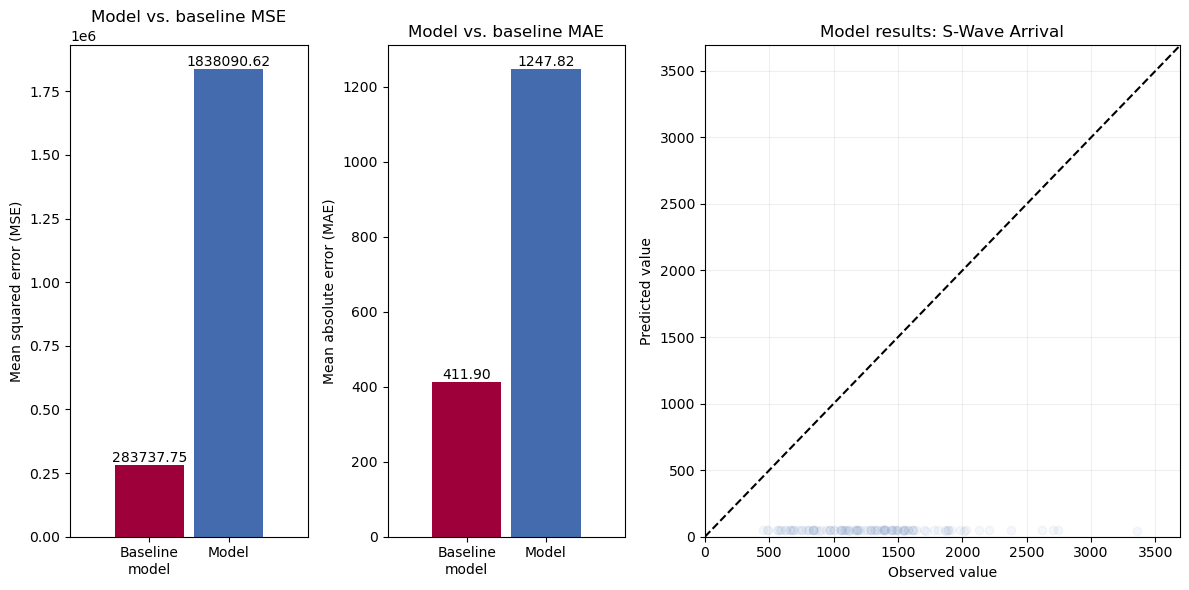

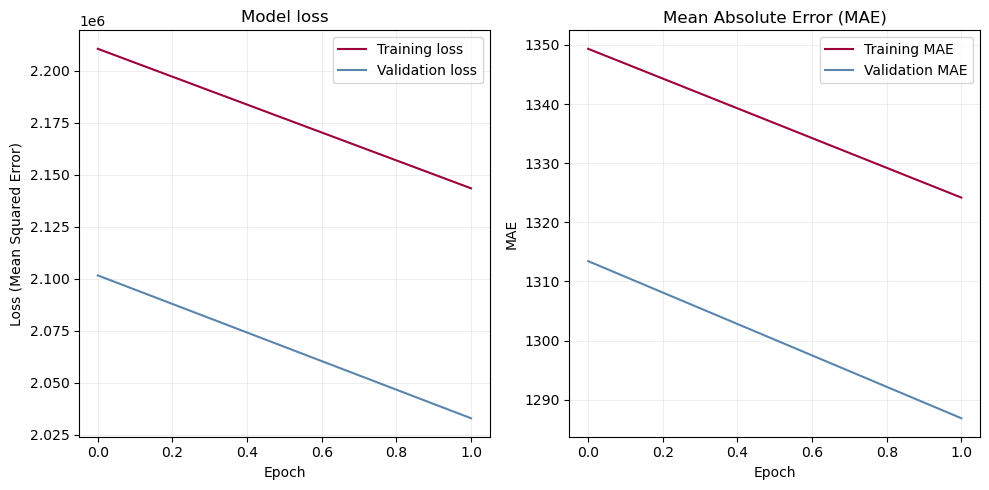

In [43]:
# Set up model callbacks
epochs = 2
callbacks_swave = architectures.callbacks_setup(model_tag='cnn_regression_swave', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['s_arrival_sample'])
train_dataset_swave, val_dataset_swave, test_dataset_swave = training_utils.prepare_datasets(imgs=waveform_imgs_earthquakes_only, labels=labels, preproc_func=architectures.image_preprocessing, preproc_func_kwargs=waveform_kwargs, use_scaler=False, batch_size=32)
model_swave = architectures.build_compile_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_swave_history = model_swave.fit(train_dataset_swave, epochs=epochs, callbacks=callbacks_swave, validation_data=val_dataset_swave)

# Evaluate model
training_utils.evaluate_regression_model(model_swave, train_dataset_swave, test_dataset_swave, 'S-Wave Arrival', scaler=None)
training_utils.plot_training_history(model_swave_history)

### 5. Regression CNN model training & evaluation to predict earthquake source-receiver distance (km)

Epoch 1/2
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 4349.2559 - mae: 47.9070 - val_loss: 3871.8987 - val_mae: 43.4946 - learning_rate: 1.0000e-05
Epoch 2/2
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 2913.2197 - mae: 38.4836 - val_loss: 3372.2068 - val_mae: 42.6699 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 2.
Evaluating model on test dataset
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 1972.7949 - mae: 35.9656
Test data MSE: 2145.392822265625
Test data MAE: 35.75785827636719
Getting predictions
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step


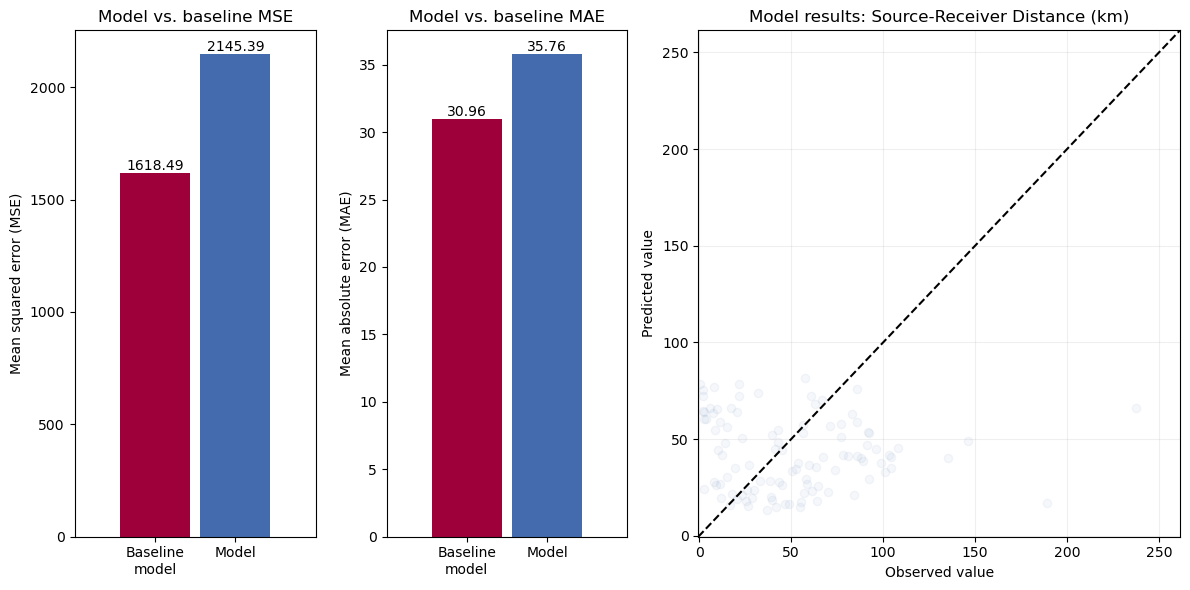

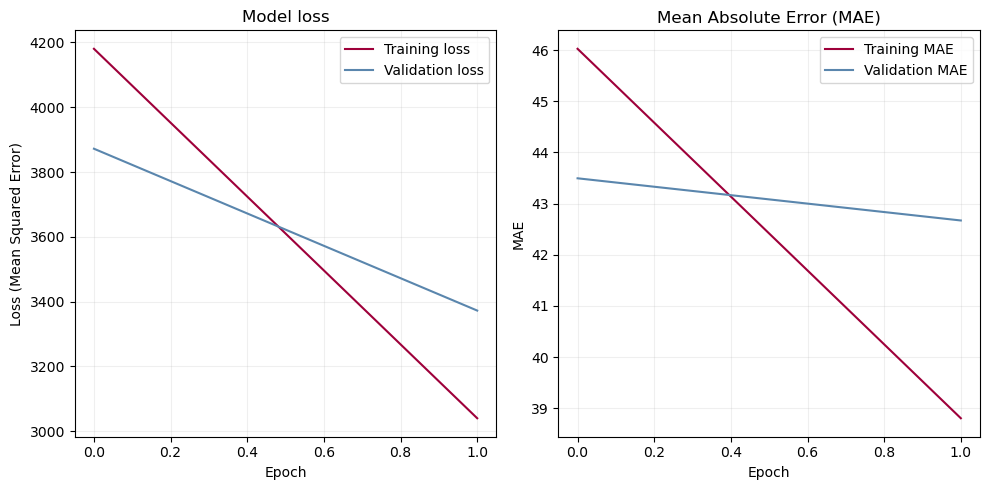

In [44]:
# Set up model callbacks
epochs = 2
callbacks_dist = architectures.callbacks_setup(model_tag='cnn_regression_distance', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['source_distance_km'])
train_dataset_dist, val_dataset_dist, test_dataset_dist = training_utils.prepare_datasets(imgs=spectrogram_imgs_earthquakes_only, labels=labels, preproc_func=architectures.image_preprocessing, preproc_func_kwargs=waveform_kwargs, use_scaler=False, batch_size=32)
model_distance = architectures.build_compile_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_distance_history = model_distance.fit(train_dataset_dist, epochs=epochs, callbacks=callbacks_dist, validation_data=val_dataset_dist)

# Evaluate model
training_utils.evaluate_regression_model(model_distance, train_dataset_dist, test_dataset_dist, 'Source-Receiver Distance (km)', scaler=None)
training_utils.plot_training_history(model_distance_history)

### 6. Regression CNN model training & evaluation to predict earthquake depth (km)

Epoch 1/2
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 979.2313 - mae: 16.0268 - val_loss: 235.6227 - val_mae: 9.2802 - learning_rate: 1.0000e-05
Epoch 2/2
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 895.0310 - mae: 15.7306 - val_loss: 245.0515 - val_mae: 10.9639 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 1.
Evaluating model on test dataset
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 418.6203 - mae: 10.9712
Test data MSE: 455.24053955078125
Test data MAE: 11.548521041870117
Getting predictions
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step


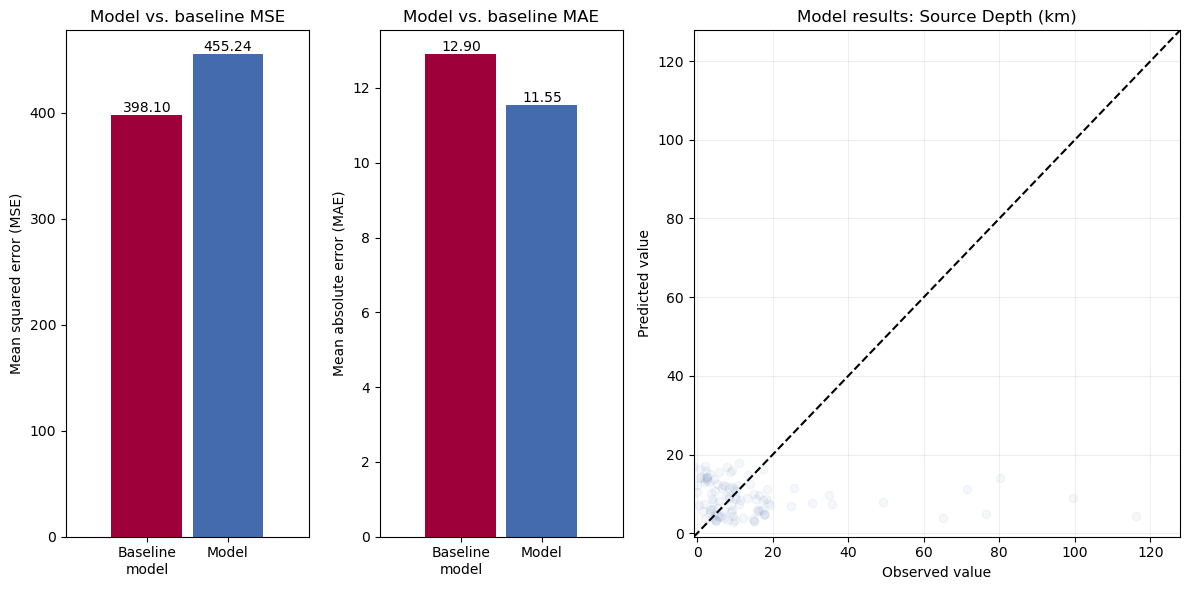

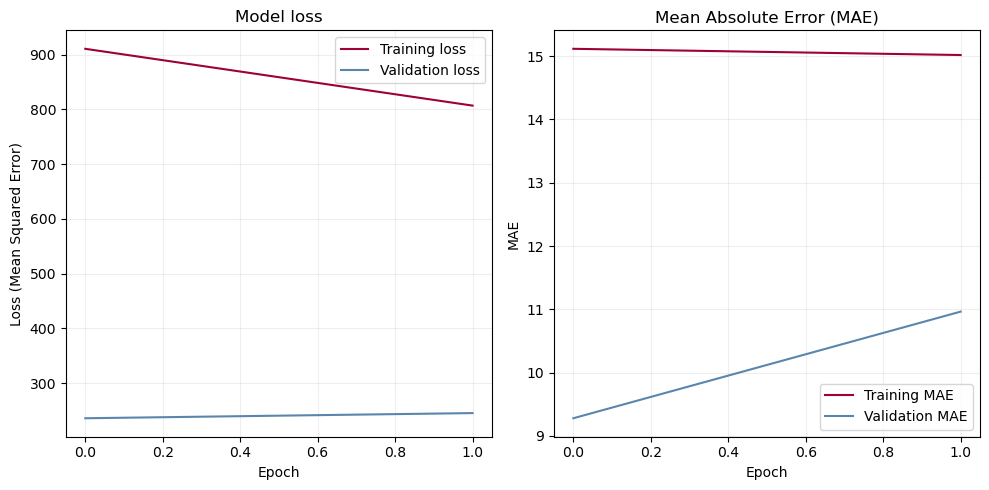

In [45]:
# Set up model callbacks
epochs = 2
callbacks_depth = architectures.callbacks_setup(model_tag='cnn_regression_depth', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['source_depth_km'])
train_dataset_depth, val_dataset_depth, test_dataset_depth = training_utils.prepare_datasets(imgs=spectrogram_imgs_earthquakes_only, labels=labels, preproc_func=architectures.image_preprocessing, preproc_func_kwargs=waveform_kwargs, use_scaler=False, batch_size=32)
model_depth = architectures.build_compile_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_depth_history = model_depth.fit(train_dataset_depth, epochs=epochs, callbacks=callbacks_depth, validation_data=val_dataset_depth)

# Evaluate model
training_utils.evaluate_regression_model(model_depth, train_dataset_depth, test_dataset_depth, 'Source Depth (km)', scaler=None)
training_utils.plot_training_history(model_depth_history)